# `random_algebra`

### Random Variable Algebra With SciPy Probability Distributions

This is intended to be a small library that extends `scipy.stats` that facilitates some simple algebra with random variables (without having to resort to a monte-carlo approach) using numerical integration from `scipy.optimize`.

With the simple statement,

```python
import random_algebra
```

By monkeypatching the `scipy.stats.rv_frozen` class that is inherited by all frozen probability distributions, we can modify the way that these objects interact with each other and interact with numeric constants. 

Given that `x`, `y` are random variables and `a` is a float, the following methods are available:
- `scale`: multiplying a random variable by a constant, `scale(x, a) = a * x`
- `offset`: adding a random variable to a constant, `offset(x, a) = a + x`
- `add`: adding two random variables, `add(x, y) = x + y`
- `multiply`: multiplying two random variables, `multiply(x, y) = x * y`
- `inverse`: finding the multiplicative inverse of two random variables, `inverse(x) = 1 / x`
- `posterior`: finding the posterior given two random variables representing the likelihood and prior, `posterior(x, y) = x and y`
- division of two random variables is also possible within this framework, `multiply(x, inverse(y)) = x / y`
- `power`: raising a random variable to an integer power, `power(x, a) = x**a`
- `exp`: exponentiating a random variable, `exp(a, x) = a**x = np.exp(x * np.log(a))`
- `log`: taking the log of a random variable, `log(x, base=a) = np.log(x)/np.log(a)`
- `abs_val`: taking the absolute value of a random variables, `abs_val(x) = abs(x)`
- `either`: that a random variable could come with equal probability from one of two distributions, `either(x, y) = x | y`

There are also several methods that take a list of distributions as input, `dists = [x, y, ... ]`:
- `combination`: that a random variable could come from the input distributions `[x, y, ... ]` with probabilities `[p_x, p_y, ...]` is given by `combination([x, y, ...], [p_x, p_y, ...])`.
- `order_statistic`: The probability distribution for the $k^{\rm{th}}$ order statistic (where `k in range(len(dists))` is given by `order_statistic(k, dists)`.
- `min_statistic`: The probability distribution for the min value amongst a series of random variables, `min_statistic(dists) = order_statistic(0, dists)`
- `max_statistic`: The probability distribution for the max value amongst a series of random variables, `max_statistic(dists) = order_statistic(len(dists) - 1, dists)`
- `median`: The probability distribution for the central value, in the case that `len(dists)` is odd, otherwise, the mean of the two central values.
- `mean`: The probability distribution for the mean of the input random variables, `mean(dists) = sum(dists) / len(dists)`

Here are some examples of manipulating scipy.stats distributions using this package:

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=1.3)

from random_algebra import posterior, plot_dist

from scipy.stats import beta, uniform, norm

### Simple Algebraic Manipulation and Plotting

Then, simple linear functions of the distribution objects result in new probability distribution objects. For example, here `c` is a random variable that is distribute like the difference between two beta distributed variables:

In [2]:
a = beta(4,1)
b = beta(10,4)
c = a - b

Inequalities operated on these objects result in probabilites that the inequality is true. Additionally, since these objects can quickly become complex, and hence computationally intensive, we can export normal approximations to these objects at any time.

In [3]:
print("P(a > b) = %.3f numerical calculation" % (a > b))
print("P(a > b) = %.3f normal approximation" % ((a - b).get_normal_approx() > 0))
print("P(a > b) = %.3f log-gamma approximation" % ((a - b).approx("loggamma") > 0))

P(a > b) = 0.700 numerical calculation
P(a > b) = 0.665 normal approximation
P(a > b) = 0.690 log-gamma approximation


I have included a simple plot function to compare a probability distribution with an empirically generated histogram of samples from that distribution, and the normal approximation to that distribution.

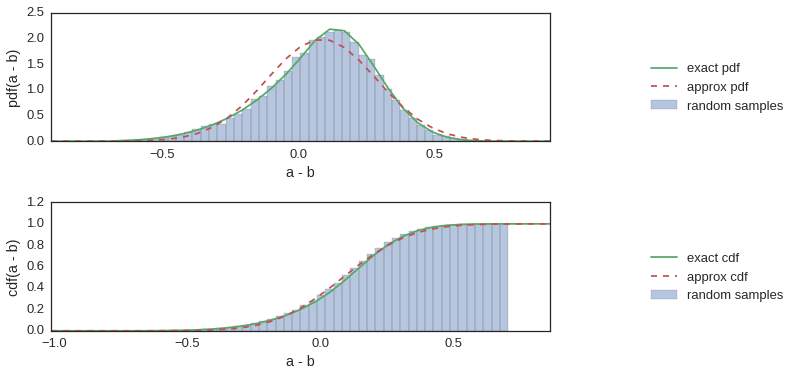

In [4]:
plot_types = ["pdf", "cdf"]

for i, plot_type in enumerate(plot_types):
    plt.subplot(len(plot_types), 1, i + 1)
    
    plot_dist(c,
              n=35, samples=20000,
              type=plot_type)
    
    plt.xlabel('a - b')
    plt.ylabel(plot_type + '(a - b)')
    
plt.tight_layout()

Here is another example in which case we are computing the difference between two uniform distributions of different widths.

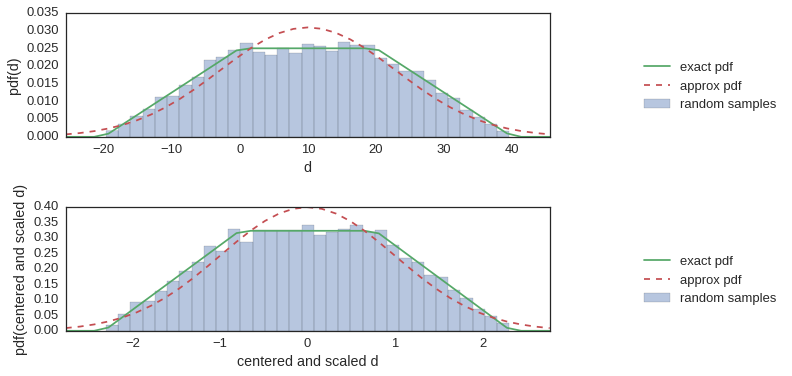

In [5]:
d = 20 * (2 * uniform() - uniform())

plt.subplot(2,1,1)
plot_dist(d)
plt.ylabel("pdf(d)")
plt.xlabel('d')

centered_and_scaled_d = (d - d.mean())/d.std()

plt.subplot(2,1,2)
plot_dist(centered_and_scaled_d)
plt.ylabel("pdf(centered and scaled d)")
plt.xlabel('centered and scaled d')

plt.tight_layout()

Using the `random_algebra.posterior` we can generate posterior distributions as per Bayes theorem as well.

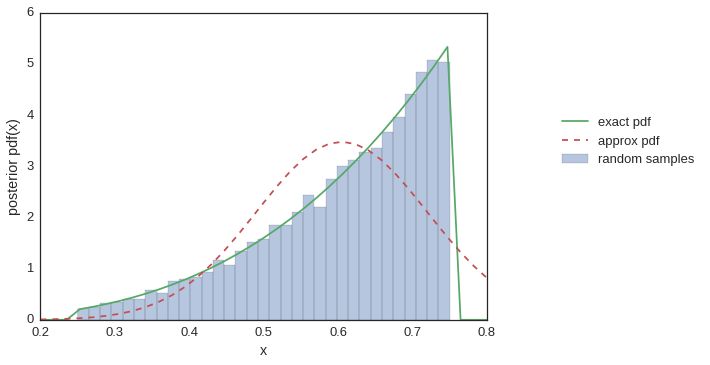

In [6]:
prior_dist      = uniform(.25, .5)
likelihood_dist = beta(4, 1)

posterior_dist  = posterior(likelihood_dist, prior_dist)

plot_dist(posterior_dist)
plt.xlabel('x')
_ = plt.ylabel('posterior pdf(x)')

I have overridden the `rv_frozen` `__str__` and `__repr__` methods to provide a useful representation of the operations that are being performed to evaluate a probability distribution after performing some algebra with random variables. Here is an example:

In [7]:
x = beta(5, 6)
y = uniform()
z = norm(2)

d = 5 * x / y - z + 1

print(d)

offset(
   add(
      multiply(
         scale(
            beta(5, 6),
            5.0
         ),
         inverse(
            uniform()
         )
      ),
      norm(-2.0, -1.0)
   ),
   1.0
)


### Statistics on Array Variables

In this section we will explore use of some of the functions available for manipulating arrays of random variables.

In [8]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=1.3)

from random_algebra import plot_dist, combination,\
                           order_statistic, min_statistic, median, max_statistic

from scipy.stats import binom, beta

Lets consider the case where we have a binomial random number generator `binom_var` and from that we perform a series of experiments by sampling from this distribution to infer the the probability $p$ of obtaining a positive result for each bernoulli trial. The distribution for p is beta distributed as follows:

In [9]:
N, p, samples = 10, .75, 7
binom_var = binom(N, p)

beta_vars = []
for i in range(samples):
    
    n = binom_var.rvs()
    
    beta_vars.append(
        beta(n + 1, N - n + 1)
    )
    
print(beta_vars)

[beta(9, 3), beta(8, 4), beta(8, 4), beta(10, 2), beta(10, 2), beta(7, 5), beta(8, 4)]


In the case in which we do not know whether or not the value for $p$ was the same in each experiment, we may be interested in the order statistics for the value for $p$ for each experiment (though normally we may only be interested in the min, max and median).

Here, we draw samples for each of the order statistics rather than computing the probabability distribution directly, since this is factorially hard in the number of random variables. Additionally, we approximate these distributions with log-gamma distributions which are characterized by their mean, variance, and skewness, so as to capture the skewness of the distributions of the order statistics.

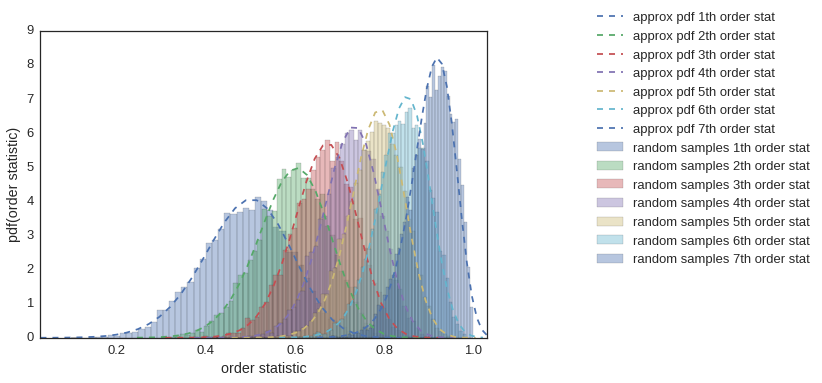

In [10]:
beta_order_stats = [order_statistic(i, beta_vars) 
                    for i in range(len(beta_vars))]

labels = [str(i + 1) + 'th order stat' 
          for i in range(len(beta_order_stats))]

plot_dist(beta_order_stats,
          labels=labels,
          show_dist=False,          # dont compute actual distributions - too computationally expensive
          show_random_samples=True, # show histograms of random samples instead - easy to compute
          legend_loc=(1.75, 1.1),
          show_approx=True,         # fit the resulting histograms to an approximate distribution
          approx_options=dict(type="loggamma",    # model these distributions as loggamma (accounts for skewness)
                              from_samples=True)) # model them from the samples rather than from numerical integration

plt.xlabel('order statistic')
_ = plt.ylabel('pdf(order statistic)')

Here is another example - lets consider a random variable that has equal probability of being drawn from a folded normal distribution and an exponential distribution. This distribution can be approximated, by using `sklearn.mixture.GaussianMixture` functionality, as a mixture of gaussians. Both of these distribution make use of the `combination` function.


exact  : combination(
   [foldnorm(3.4999999999999969, 0, 1.0000000000000009),
    expon()],
   [0.5,
    0.5]
)

approx : combination(
   [norm(3.1761569709067068, 1.1724160062142475),
    norm(0.51774263468800275, 0.3782367290885677)],
   [0.647560759141,
    0.352439240859]
)



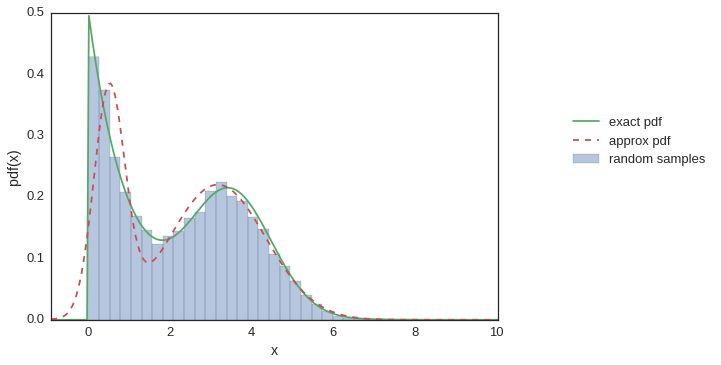

In [11]:
from scipy.stats import norm, expon
import numpy as np

dist   = abs(norm(3.5, 1)) | expon()

approx = dist.approx(type="gaussian_mixture",
                     n_components=2)


print("""
exact  : {exact}

approx : {approx}
""".format(exact=str(dist),
           approx=str(approx))
)

plot_dist(dist, n=250,
          approx_options=dict(type="gaussian_mixture",
                              n_components=2))

plt.xlabel('x')
_ = plt.ylabel('pdf(x)')

### Special Cases

In [12]:
import sys
sys.path.append('..')

from random_algebra import mean, posterior
from scipy.stats import expon, lognorm, gamma, norm, binom, beta
import numpy as np

There are several "special cases" that have been implemented to simplify the computational graph required to evaluate the probability distributions. For example, a series of constant scalings and offsets are consolidated into a graph with a single scale and offset operator. For example:

In [13]:
print(2 * (2 * ( 2 * expon() + 1) + 1) + 1)

offset(
   scale(
      expon(),
      8.0
   ),
   7.0
)


I have also included some special properties of some probability distributions. For, example, summing and scaling normal random variables result in a random variable. For example:

In [14]:
generator = norm(0, 1)

print(mean(
        [norm(generator.rvs(), 1)
         for i in range(100)]
      ))

norm(0.072050405459060357, 0.10000000000000002)


And the posterior distribution for a beta distribution given a string on binomial likelihoods is beta, for example:

In [15]:
N = 10
p = .5
generator = binom(N, p)

print(
    reduce(posterior, [beta(n + 1, N - n + 1)
                       for n in generator.rvs(10)])
)

beta(54, 48)


Here, the exponentiation of a normal variable results in a lognormal variable, and the log of a gamma variables results in a loggamma variable (notice the inconsistency of naming between the two distributions...)

In [16]:
print(np.exp(norm(0, 1)))

lognorm(1.0,)


In [17]:
print(np.log(gamma(1)))

loggamma(1,)


There are also some strange ones that have been implemented such as this one,

In [18]:
norm(2, 3) + expon(4)

exponnorm(0.33333333333333331, 6.0, 3.0)